In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import make_pipeline
from statsmodels.tsa.holtwinters import ExponentialSmoothing

---
## **1.Data preparation**
### ELIA + MTO

In [2]:
# Retrieve data
df_elia = pd.read_csv("../../Data/ELIA.csv", sep=";")
df_mto = pd.read_csv("../../Data/MTO_BELGIQUE_18_to_25.csv", sep=",")

df_offshore = df_elia[df_elia["Offshore/onshore"] == "Offshore"].copy()         # Keep only Offshore rows
df_offshore["Datetime"] = pd.to_datetime(df_offshore["Datetime"], utc=True)     # Convert Datetime to actual datetime
df_offshore = df_offshore.dropna(how="any")                                     # Drop empty rows
df_offshore = df_offshore.sort_values("Datetime").reset_index(drop=True)        # Sort values in chronological order

df_mto["valid_time"] = pd.to_datetime(df_mto["valid_time"], utc=True)           # Convert Datetime to actual datetime
df_mto = df_mto.dropna(how="any")                                               # Drop empty rows
df_mto = df_mto.sort_values("valid_time").reset_index(drop=True)                # Sort values in chronological order

print("Offshore data")
print("=================================================")
print("Oldest date :", df_offshore["Datetime"].min())
print("Newest date :", df_offshore["Datetime"].max())
print("")
print("MTO data")
print("=================================================")
print("Oldest date :", df_mto["valid_time"].min())
print("Newest date :", df_mto["valid_time"].max())

# Visualization options
#df_elia.head(5)
df_offshore.head(3)
#df_mto.head()

Offshore data
Oldest date : 2016-01-12 23:00:00+00:00
Newest date : 2025-12-01 22:45:00+00:00

MTO data
Oldest date : 2018-01-01 00:00:00+00:00
Newest date : 2025-11-23 23:00:00+00:00


,Datetime,Resolution code,Offshore/onshore,Region,Grid connection type,Measured & Upscaled,Most recent forecast,Most recent P10,Most recent P90,Day Ahead 11AM forecast,...,Day Ahead 11AM P90,Day-ahead 6PM forecast,Day-ahead 6PM P10,Day-ahead 6PM P90,Week-ahead forecast,Week-ahead P10,Week-ahead P90,Monitored capacity,Load factor,Decremental bid Indicator
0,2016-01-12 23:00:00+00:00,PT15M,Offshore,Federal,Elia,645.93,655.86,599.65,699.22,653.09,...,687.96,654.86,618.64,687.21,348.91,79.18,618.63,712.2,0.91,''
1,2016-01-12 23:15:00+00:00,PT15M,Offshore,Federal,Elia,645.93,657.63,601.69,699.71,653.22,...,688.41,655.59,618.27,687.96,346.07,75.74,616.39,712.2,0.91,''
2,2016-01-12 23:30:00+00:00,PT15M,Offshore,Federal,Elia,645.93,659.39,603.74,700.21,653.35,...,688.87,656.32,617.91,688.71,343.22,72.30,614.14,712.2,0.91,''


### Merge ELIA + MTO

In [3]:
# Convert ELIA to hourly resolution => Only keeps hourly timestamps (the rest are dsicarded)
df_offshore_hourly_exact = df_offshore[df_offshore["Datetime"].dt.minute == 0].copy()
df_offshore_hourly_exact.head()

df_merged = df_offshore_hourly_exact.merge(
    df_mto,
    left_on="Datetime",
    right_on="valid_time",
    how="inner"
)
df_merged.head()

print("Merged data")
print("=================================================")
print("Oldest date :", df_merged["Datetime"].min())
print("Newest date :", df_merged["Datetime"].max())

Merged data
Oldest date : 2018-01-01 00:00:00+00:00
Newest date : 2025-11-23 23:00:00+00:00


---
## **2. MLP Regressor** (supervised sequential dataset)

In [9]:
df_ts = df_offshore

target_col = "Measured & Upscaled"  # adapte si le nom est différent
y_series = df_ts[target_col].values

time_series = df_ts["Datetime"].values

H = 24          # Pour prédire la valeur à l’instant t, on utilise les 24 valeurs précédentes
HORIZON = 12    # prédire 24 pas dans le futur

X_seq = []
y_seq = []
time_seq = []

for t in range(H, len(y_series) - HORIZON):
    # fenêtre séquentielle : les H derniers points
    X_seq.append(y_series[t-H:t])

    # label : la valeur t + horizon
    y_seq.append(y_series[t + HORIZON])

    # timestamp associé à la prédiction
    time_seq.append(time_series[t + HORIZON])

X_seq = np.array(X_seq)   # shape (N, H)
y_seq = np.array(y_seq)   # shape (N,)
time_seq = np.array(time_seq)

print("X_seq:", X_seq.shape)
print("y_seq:", y_seq.shape)


train_size = int(0.8 * len(X_seq))

X_train = X_seq[:train_size]
y_train = y_seq[:train_size]

X_test  = X_seq[train_size:]
y_test  = y_seq[train_size:]
time_test = time_seq[train_size:]

X_seq: (337492, 24)
y_seq: (337492,)


In [10]:
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error
import numpy as np
from sklearn.preprocessing import StandardScaler

# --- scaling X (fenêtres de MW) ---
scaler_X = StandardScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled  = scaler_X.transform(X_test)


mlp_seq = MLPRegressor(
    hidden_layer_sizes=(32,),
    activation="relu",
    max_iter=200,
    random_state=0,
    early_stopping=True,
    validation_fraction=0.1,
    alpha=1e-3,          # petit poids de régularisation L2
)


mlp_seq.fit(X_train_scaled, y_train)
y_pred = mlp_seq.predict(X_test_scaled)

mse  = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

print("Expert séquentiel MLP - MSE :", mse)
print("Expert séquentiel MLP - RMSE :", rmse)


Expert séquentiel MLP - MSE : 109867.6532371301
Expert séquentiel MLP - RMSE : 331.4628987339761


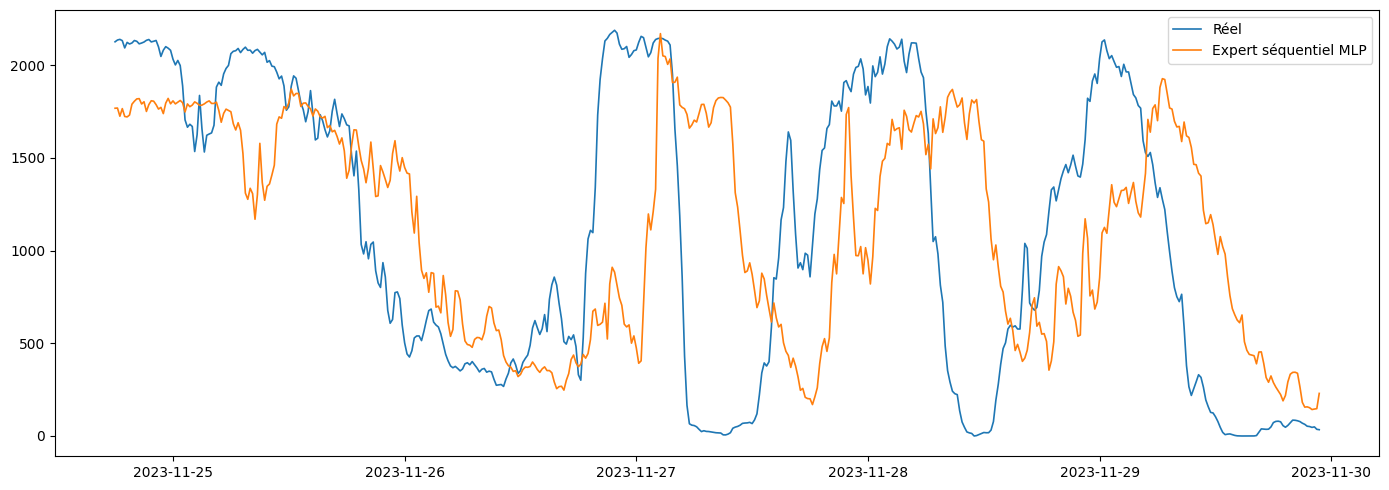

In [6]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14,5))

N = 500  # nombre de points à afficher
plt.plot(time_test[:N], y_test[:N], label="Réel", linewidth=1.2)
plt.plot(time_test[:N], y_pred[:N], label="Expert séquentiel MLP", linewidth=1.2)

plt.legend()
plt.tight_layout()
plt.show()
